<h1>Expansion to a stochastic problem (S-ICEP)</h1>

During the planning stage, it is not possible to know how a disaster will turn out and where and how many people have to
be evacuated. The underlying uncertainty affects a variety of factors: which resources are actually useful, the route choices the
resources have to take, how many trips each of the resources have to complete, and ultimately what the resulting evacuation time
is. Based on the D-ICEP, emergency planners want to optimally select a fleet of recovery resources that can handle a variety of
evacuation scenarios, given the ability of a resource to reduce evacuation time and offer competitive cost structures. The model
takes into account the costs of choosing a resource as part of the fleet, variable operating costs, such as labor and fuel, as well
as the calculated cost of the loss of a human life

We start as before with parameters setup 

In [1]:
from unicodedata import name
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
import random
import math
import pandas as pd
import runExpeStoc
import generateData
import generateSimpleData
from classes.utils import Utils
from classes.plotting import Plotting

random.seed(123)

num_i = 10               # Number of potential resources for evacuation purpouses
num_a = 3               # Number of areas to be evacuated
num_b = 4               # Number of pickUp points where people are loaded on rescue vehicles
num_c = 3               # Number of shelters where people are dropped off
num_h = 1               # Number of initial locations from where rescue resources depart
num_t = 1               # Number of sink node (to not be changed)
num_selfEva = 25        # Number of self evacuees (people that can safe themselfs)
numClas = 1             # Number of classes of rescue resources
numScenarios = 6        # Number of different scnearios
upperTimeLimit = 100    # Upper time limit parameter 
T = upperTimeLimit
penalty = 1.5             # Penalty for not evacuating people
evaDemand = [70,90]   # Evacuation demand range for each evacuation area a (data is randomly generated inside this range)
params = dict()
params['upperTimeLimit'] = upperTimeLimit
params['penalty'] = penalty

We can also select two different objective functions (see paper for complete formulation)
<ol>
    <li>  <img src="images/bal_1.png" alt="First obj function" width="50%" height="50%" /> </li>
    <li> <img src="images/bal_2.png" alt="Second obj function" width="50%" height="50%" /> </li>
</ol>

Note that the only difference is the first term in squared brackets:
The first aims to minimize the overall evacuation time (upper bound of all resource times), while the second tries to reduce individual resource route completion times. 


In [2]:
objFunction = {         
    1 : 'bal_1',
    2 : 'bal_2'
}
params['objFunction'] = objFunction[1]      # Change index for correspondent obj function

Additionally, since we have not control on how many people could be left behind (it depends on the number of max round trips and penalty parameter), one could be interested in setting a minimum percentage of pupulation to be saved:

In [3]:
m = 0                                       # m is % of people that must be saved (if left 0 constraint 38 is not added)
params['percentToEva'] = m                  # See Eq. 38 in 'runExpeStoc.py'
if m == 0:
    params['force_eva_percent'] = False
else:
    params['force_eva_percent'] = True

So now we are ready to run our data generation and check graphically nodes positions and arcs

=========Creating nodes=========
=========End creating nodes=========
=========Populationg scenarios=========
=========End creating Scenarios=========
=========Creating resources=========
=========End creating resources=========
=========Computing k values=========
=========End computing k values=========
=========Creating Arcs=========
=========End creating arcs=========
=========Start writing data=========
=========End writing data=========


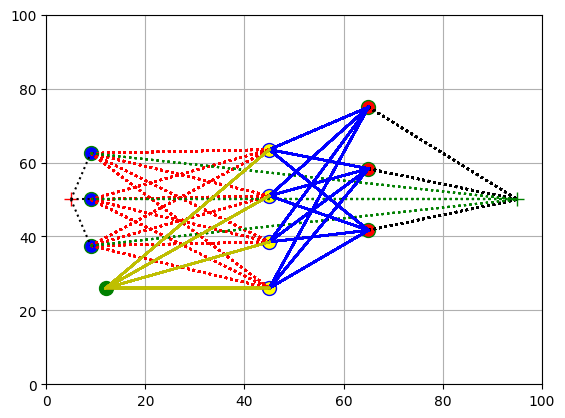

In [4]:
data = generateData.generateData(num_i, num_a, num_h, num_b, num_c, num_selfEva, evaDemand, numClas, numScenarios)

plotting = Plotting(data)
plotting.plotBase()
plotting.plotResourceArcs()


Let's run the optimization tool:

In [5]:
status, runtime, objVal, experiment = runExpeStoc.runExpeStochastic(data, params)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-16


Once the solution is found we can assess it by looking at scenarios table

In [6]:
df = pd.DataFrame(columns=['probability', 'severity', 'speedCoeff', 'loadingCoeff', 'maxRoundTrips'])
scenarios = data['scenarios']
probabilities = [sc.probability for sc in scenarios]
df['probability'] = probabilities
severities = [sc.severity for sc in scenarios]
speedCoeffs = [sc.speedCoeff for sc in scenarios]
loadCoeffs = [sc.loadingCoeff for sc in scenarios]
notEva, key = Utils.getVars(Utils, experiment.getVars(), 'numNotEva_mean')

df['severity'] = severities
df['speedCoeff'] = speedCoeffs
df['loadingCoeff'] = loadCoeffs
df['maxRoundTrips'] = [sc.num_k for sc in scenarios]
df['Not Evacuated'] = [int(abs(ne)) for ne in notEva]
df['Penalty'] = [penalty] + ['']*(numScenarios-1)

df

,probability,severity,speedCoeff,loadingCoeff,maxRoundTrips,Not Evacuated,Penalty
0,0.480924,2,0.694444,1.305556,2,0,1.5
1,0.278149,4,0.216110,1.783890,2,0,
2,0.002820,3,0.421875,1.578125,2,0,
3,0.075490,3,0.421875,1.578125,2,0,
4,0.106439,0,1.000000,1.000000,2,0,
5,0.056179,4,0.216110,1.783890,2,0,


And also check resource fleet selection 

In [7]:
df = pd.DataFrame(columns=['is_in_fleet', 'Time mins', 'MeanVarCost €', 'FixedCost €'])
isResInFleet, key = Utils.getVars(Utils, experiment.getVars(), 'isResInFleet')
meanTimeForResourceI , key = Utils.getVars(Utils, experiment.getVars(), 'meanTimeForResourceI')



meanTimeForResourceI = [math.floor(mt * 100)/100 for mt in meanTimeForResourceI]
costs = []
fixedCosts = []
for i in range(num_i):
    costs.append( data['resources'][i].varCost * meanTimeForResourceI[i])
    fixedCosts.append(data['resources'][i].fixedCost)
df['is_in_fleet'] = [math.floor(abs(rs)) for rs in isResInFleet]
df['Time mins'] = [math.floor(mt * 100)/100 for mt in meanTimeForResourceI]
df['MeanVarCost €'] = costs
df['FixedCost €'] = fixedCosts
df['Resource class'] = [ res.clas for res in  data['resources']]
df['Speed (Km/h)'] = [res.emptySpeed * 60 for res in data['resources']]
df['Mean distance'] = [meanTimeForResourceI[i]/data['resources'][i].emptySpeed for i in range(num_i)]
df['Capacity'] = [res.capacity for res in data['resources']]



df

,is_in_fleet,Time mins,MeanVarCost €,FixedCost €,Resource class,Speed (Km/h),Mean distance,Capacity
0,0,0.00,0.000,100000,0,60,0.00,25
1,0,0.00,0.000,10000,0,60,0.00,27
2,1,65.84,1679.175,170000,0,60,65.85,28
3,1,60.13,270.585,30000,0,60,60.13,30
4,1,66.77,1802.790,180000,0,60,66.77,27
5,1,55.49,1581.465,190000,0,60,55.49,25
6,0,0.00,0.000,120000,0,60,0.00,15
7,1,70.08,1051.200,100000,0,60,70.08,30
8,0,0.00,0.000,50000,0,60,0.00,29
9,1,63.02,94.530,10000,0,60,63.02,19
